In [20]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

from math import sqrt

In [3]:
train = pd.read_csv('C:/Users/91798/Documents/Air_Quality_Project/train.csv')
test = pd.read_csv('C:/Users/91798/Documents/Air_Quality_Project/test.csv')

In [4]:
print('No. of rows and columns in train dataset :', train.shape)
print('No. of rows and columns in test dataset :', test.shape)

No. of rows and columns in train dataset : (79023, 76)
No. of rows and columns in test dataset : (24353, 75)


In [5]:
# making a table of null values and percent empty values 
def nulls_summary(df):
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = (null_values[0]/len(df) ) *100
    null_values.columns = ['null_count','null_percentage']
    return null_values

nulls_summary(train).sort_values(by = 'null_percentage',ascending=False).head(10)

,null_count,null_percentage
UvAerosolLayerHeight_aerosol_height,78584,99.444466
UvAerosolLayerHeight_solar_zenith_angle,78584,99.444466
UvAerosolLayerHeight_solar_azimuth_angle,78584,99.444466
UvAerosolLayerHeight_sensor_azimuth_angle,78584,99.444466
UvAerosolLayerHeight_aerosol_pressure,78584,99.444466
UvAerosolLayerHeight_aerosol_optical_depth,78584,99.444466
UvAerosolLayerHeight_sensor_zenith_angle,78584,99.444466
NitrogenDioxide_tropopause_pressure,18320,23.183124
NitrogenDioxide_stratospheric_NO2_column_number_density,18320,23.183124
NitrogenDioxide_NO2_slant_column_number_density,18320,23.183124


### Handeling NaN values 

Earlier I tried filling values with the median value of the column, but the RMS value was too high.

- **Other Ways of Handling the NaN Values**:

  - Drop Features
  - Impute Missing Values using Backward and Forward Fill
  - Impute Missing Values using Interpolation
  - Imputation using Sklearn KNN Imputer (SimpleImputer)
  - Imputation using Multivariate


*Now first I will drop the values with high null percentages and then I will use Sklearn KNN imputer to fill the NaN values.*

In [6]:
print('Number of rows and columns before dropping: ',train.shape)
print('Total number of missing values before dropping: ',train.isnull().sum().sum())
print('-----------------------------------------------------------------')
train = train.drop(['UvAerosolLayerHeight_aerosol_height','UvAerosolLayerHeight_solar_zenith_angle','UvAerosolLayerHeight_solar_azimuth_angle','UvAerosolLayerHeight_sensor_azimuth_angle','UvAerosolLayerHeight_aerosol_pressure','UvAerosolLayerHeight_aerosol_optical_depth','UvAerosolLayerHeight_sensor_zenith_angle'] ,axis=1)
print('Number of rows and column after dropping: ',train.shape)
print('Total number of missing values after dropping: ',train.isnull().sum().sum())

Number of rows and columns before dropping:  (79023, 76)
Total number of missing values before dropping:  990091
-----------------------------------------------------------------
Number of rows and column after dropping:  (79023, 69)
Total number of missing values after dropping:  440003


In [7]:
# Filling NaN values 

train_exclude_emission = train.drop(['emission', 'ID_LAT_LON_YEAR_WEEK'], axis=1)

# Create an instance of the KNNImputer
imputer = KNNImputer(n_neighbors=2, weights='uniform', metric='nan_euclidean')  

# fit on the dataset
imputer.fit(train_exclude_emission)
data_imputed = imputer.transform(train_exclude_emission)

In [8]:
# Convert the NumPy array back to a DataFrame
data_imputed_train = pd.DataFrame(data_imputed, columns=train_exclude_emission.columns)

# Get total number of missing values for all the dataset
total_missing = data_imputed_train.isnull().sum().sum()
print("Total missing values:", total_missing)

Total missing values: 0


In [9]:
df = data_imputed_train.copy()

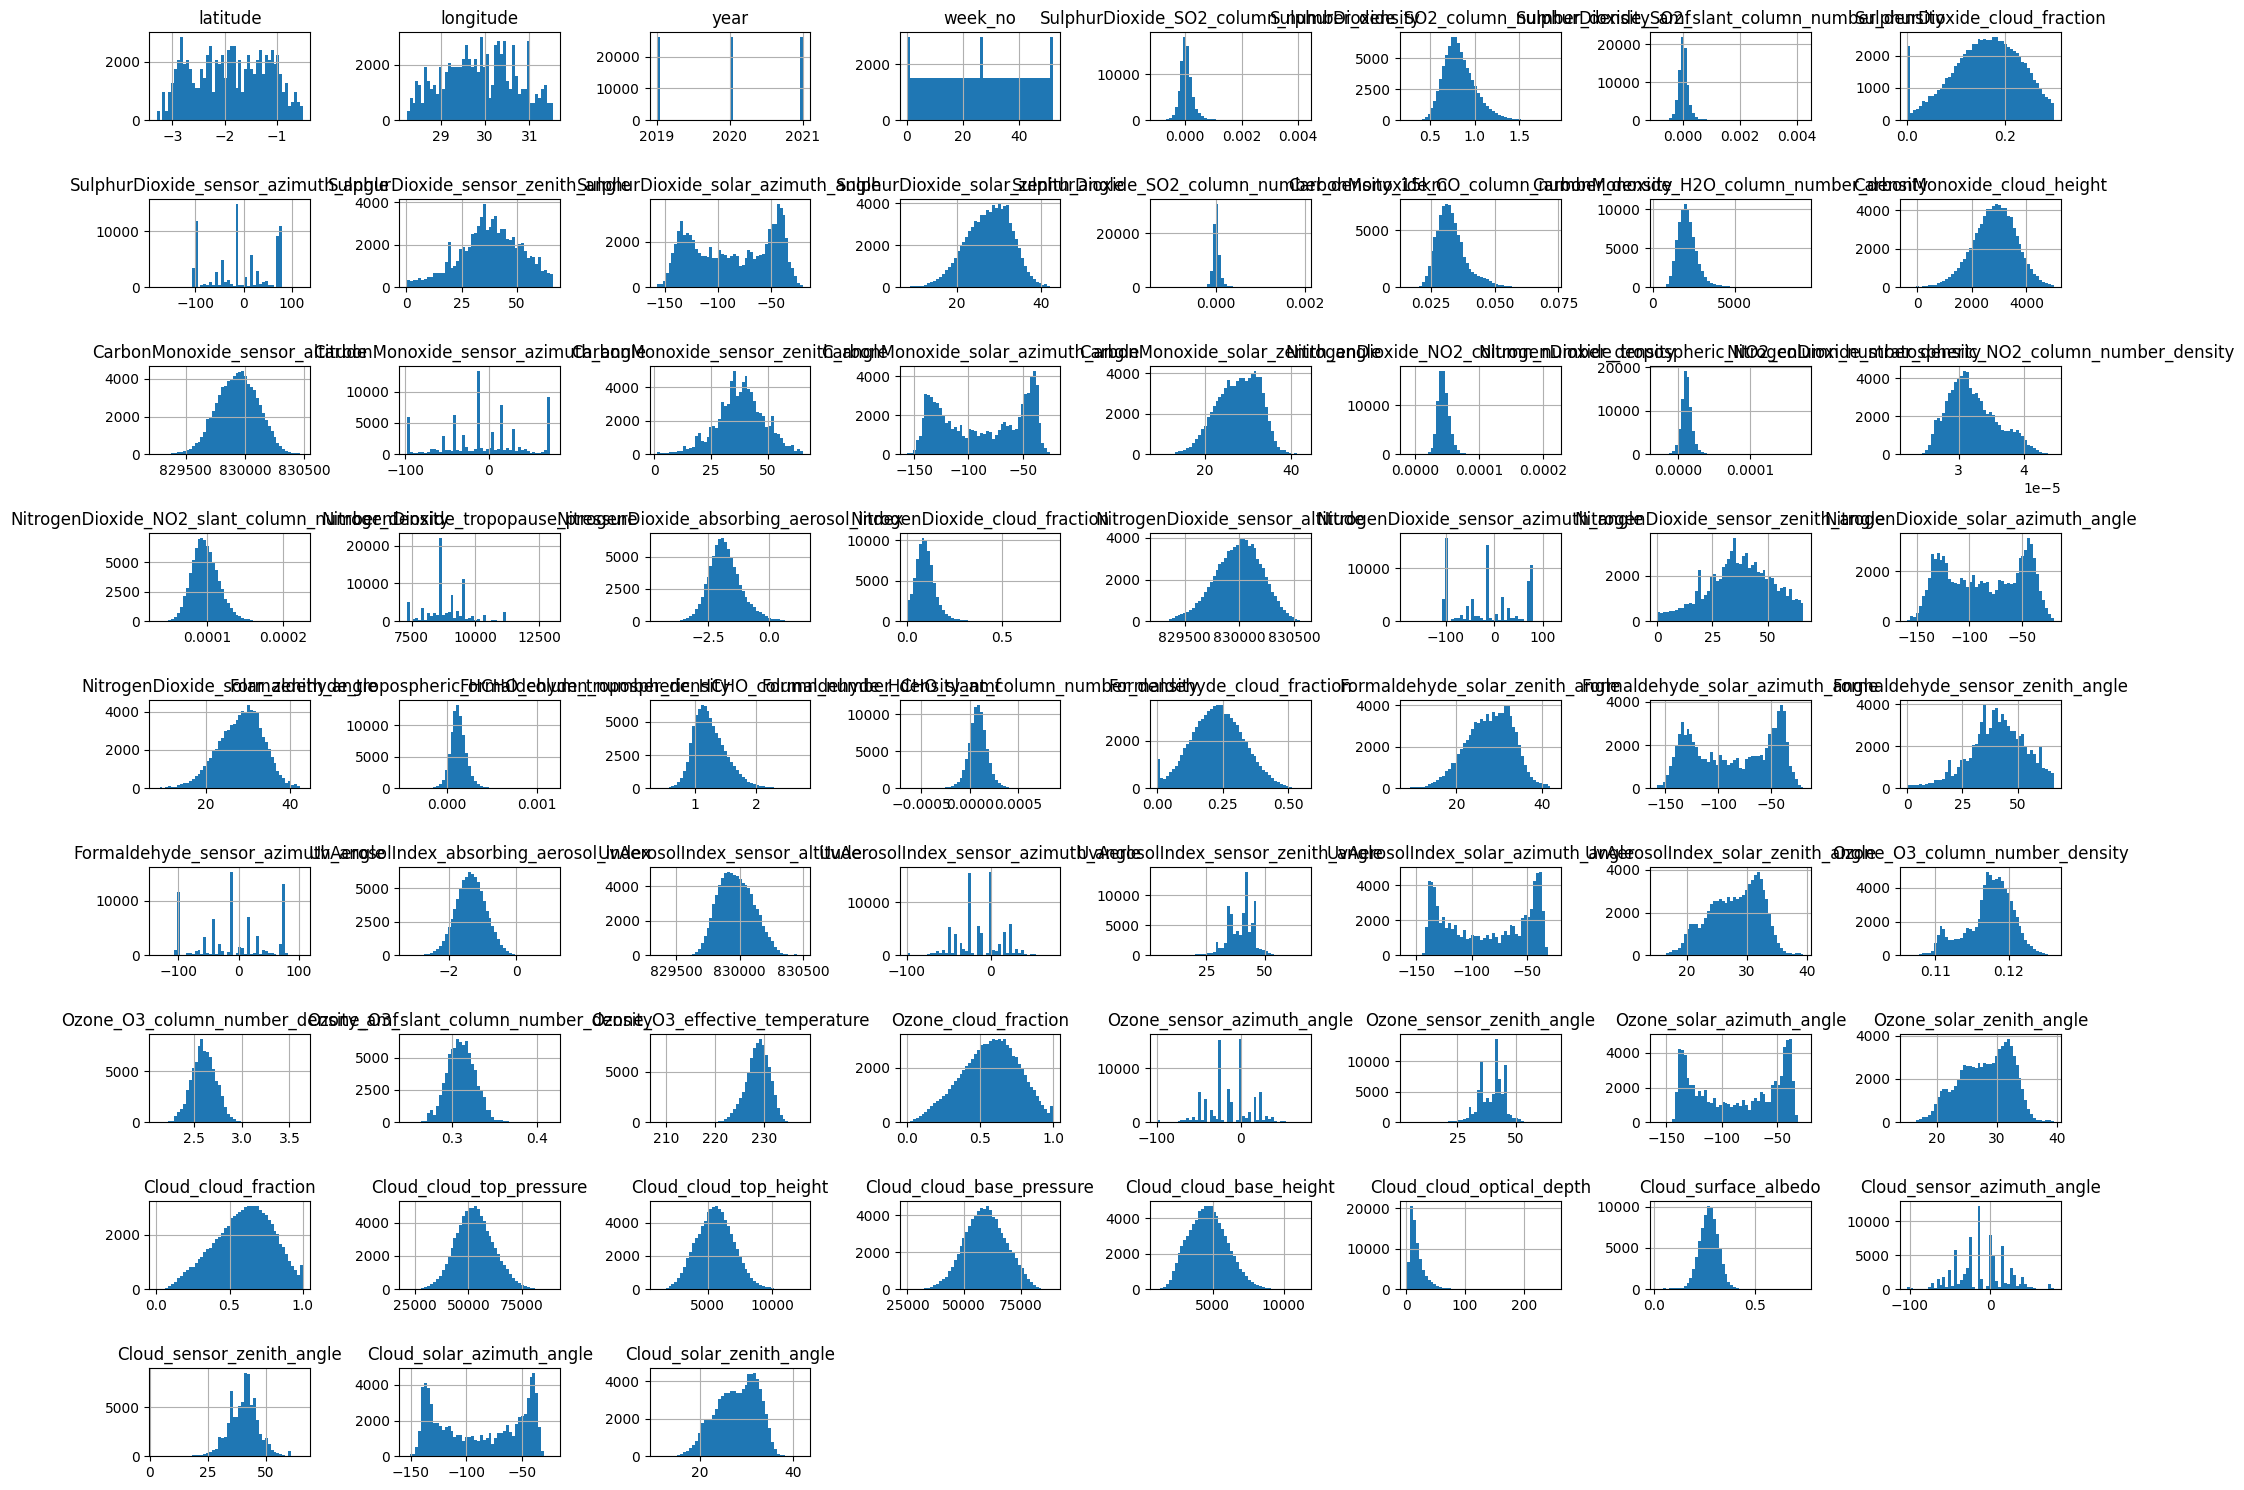

In [10]:
# Checking for potential outliers
%matplotlib inline 
df.hist(bins = 50, figsize=(20,15))
plt.tight_layout()

## Model training 

In [11]:
X = df
y = train['emission']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [13]:
print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)

(63218, 67) (63218,)
(15805, 67) (15805,)


In [14]:
# create the classifier with n_estimators = 100
model = RandomForestRegressor(n_estimators=100, random_state=0)

model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

### Features selection

In [15]:
# view the feature scores i.e, features importance
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
pd.set_option('display.float_format', '{:.4f}'.format)

print(feature_scores)

longitude                             0.7345
latitude                              0.1678
week_no                               0.0636
Ozone_O3_column_number_density        0.0033
Cloud_surface_albedo                  0.0026
                                       ...  
Ozone_sensor_azimuth_angle            0.0002
Ozone_O3_column_number_density_amf    0.0002
UvAerosolIndex_sensor_azimuth_angle   0.0002
UvAerosolIndex_sensor_zenith_angle    0.0002
Ozone_sensor_zenith_angle             0.0001
Length: 67, dtype: float64


*We can see that corelation is bad for most of the columns, therefore less importance score for most of the columns*

**We can also create some more features, i.e., emissions affected due to  COVID19**

*For that we can add a column stating the time frame of the COVID19 such that, if emissions are less in that time period it will be due to COVID19*

In [16]:
X_train['Iscovid'] = np.where((X_train['year'] == 2020) & (X_train['week_no'] >= 12) & (X_train['week_no'] <=26), 1, 0)

X_test['Iscovid'] = np.where((X_test['year'] == 2020) & (X_test['week_no'] >= 12) & (X_test['week_no'] <=26), 1, 0)

In [17]:
selected_features = ['longitude' , 'latitude' , 'week_no' , 'Ozone_O3_column_number_density' , 'Cloud_surface_albedo' ,'NitrogenDioxide_NO2_column_number_density', 'Iscovid']

In [19]:
X_train= X_train[selected_features]
X_test= X_test[selected_features]

In [21]:
scaler = MinMaxScaler() 
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.fit_transform(X_test)

X_train = pd.DataFrame(scaled_x_train, columns=X_train.columns)
X_test = pd.DataFrame(scaled_x_test, columns=X_test.columns)

### Using different models 

In [25]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

# cross validation
def test_model(reg, train, labels):

    cv = KFold(n_splits=3, shuffle=True, random_state=45)
    rmse = make_scorer(lambda y, y_pred: -sqrt(mean_squared_error(y, y_pred)))
    rmse_val_score = cross_val_score(reg, train, labels, cv=cv, scoring=rmse)
    return -rmse_val_score.mean()


#### 1. LinearRegression()

In [27]:
from sklearn.linear_model import LinearRegression

lreg = LinearRegression()
lr_rmse= test_model(lreg,X_train, y_train)
lr_rmse

146.86972211680674

**RMSE value of LinearRegression model is coming better then the earlier model**
- better null values handelling is done to improved the accuracy
- Features selection is done 
- new feature is added which have better feature importance score 
- cross validation is used 

*Comparing with some other models*

#### 2. XGBRegressor()

In [33]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb_rmse = test_model(xgb, X_train, y_train)
xgb_rmse

19.84954221341529

***This model have even better accuracy***

RMSE value of 19.8 is good enough for our analysis 

## Using XGB Regression for testing 

In [40]:
test = test.drop(columns='ID_LAT_LON_YEAR_WEEK')
test = test.drop([ 'UvAerosolLayerHeight_aerosol_height','UvAerosolLayerHeight_aerosol_pressure','UvAerosolLayerHeight_aerosol_optical_depth','UvAerosolLayerHeight_sensor_zenith_angle','UvAerosolLayerHeight_sensor_azimuth_angle','UvAerosolLayerHeight_solar_azimuth_angle','UvAerosolLayerHeight_solar_zenith_angle'] ,axis=1)


test_data_imputed = imputer.transform(test)
test = pd.DataFrame(test_data_imputed, columns=test.columns)


test['Iscovid'] = np.where((test['year'] == 2020) & (test['week_no'] >= 12) & (test['week_no'] <=26), 1, 0)

test= test[selected_features]

scaled_test = scaler.transform(test)
test = pd.DataFrame(scaled_test, columns=test.columns)

In [43]:
xgb.fit(X_train, y_train)
predictions = xgb.predict(test)

In [50]:
sub = pd.read_csv('C:/Users/91798/Documents/Air_Quality_Project/sample_submission.csv')
sub.drop('emission',axis=1,inplace=True)

In [52]:
sub['emissions'] = predictions

In [54]:
sub.to_csv('C:/Users/91798/Documents/Air_Quality_Project/predicted_emissions.csv')